# Unsupervised learning

THe exploratory analysis of the dataset was done in the exercise 6 notebook with the supervised learning. Because the dataset is the same, it will not be done again in this notebook.

For the preprocessing, it is a bit different. It can not be the same as the one done for the supervised learning, here is why:

# Target-Informed vs Statistical-Only Preprocessing

We used different preprocessing approaches for supervised and unsupervised learning tasks.

Supervised preprocessing uses target-aware feature selection (f_classif) and stratified sampling to optimize predictive performance, while unsupervised preprocessing relies purely on statistical properties (variance thresholds, correlation analysis) to discover hidden patterns without target variable influence.

The supervised approach fits scalers only on training data to prevent data leakage, uses stratified cross-validation to maintain class balance, and evaluates preprocessing choices based on prediction accuracy. 

In contrast, unsupervised preprocessing uses the entire dataset for pattern discovery, employs silhouette scores and clustering quality metrics for evaluation, and focuses on revealing data structure rather than optimizing predictive performance.

This distinction highlights how preprocessing strategy must align with the learning paradigm and analytical objectives.

# When to use unsupervised ?

- You want to discover hidden patterns in data
- No labeled data is available
- The goal is exploratory data analysis or data understanding
- You need to identify anomalies or segment populations

In [15]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage

RANDOM_STATE = 42   # full reproducibility
PLOT_KW = dict(s=18, alpha=.8, cmap="viridis")

data = load_breast_cancer()
X, y = data.data, data.target
features = data.feature_names

X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_std)
proj_2d = X_pca[:, :2]

print(f"PCA components retained: {pca.n_components_}  "
      f"(explained var = {pca.explained_variance_ratio_.sum():.2%})")

models = {
    "KMeans (k=2)": KMeans(n_clusters=2, n_init=20, random_state=RANDOM_STATE),
    "Agglomerative (Ward)": AgglomerativeClustering(n_clusters=2, linkage="ward"),
    "DBSCAN": DBSCAN(eps=1.3, min_samples=6),
    "Gaussian Mixture (2)": GaussianMixture(n_components=2,
                                            covariance_type="full",
                                            random_state=RANDOM_STATE)
}

results = {}

for name, algo in models.items():
    labels = algo.fit_predict(X_std)
    core = labels != -1 if -1 in labels else slice(None)
    sil = silhouette_score(X_std[core], labels[core]) if len(set(labels[core])) > 1 else np.nan
    ch  = calinski_harabasz_score(X_std[core], labels[core]) if len(set(labels[core])) > 1 else np.nan
    ari = adjusted_rand_score(y[core], labels[core])
    results[name] = dict(labels=labels, silhouette=sil, ch=ch, ari=ari)


PCA components retained: 10  (explained var = 95.16%)


## Standardisation

It represents a critical preprocessing step that directly addresses the extreme scale heterogeneity inherent in this dataset. The morphometric features span four orders of magnitude, ranging from proportion-based measurements like smoothness (0.05-0.22) and symmetry (0.11-0.66) to geometric features such as area (143-4,254 μm²) and perimeter (44-251 μm). Without standardisation, Euclidean-based distance metrics would be dominated entirely by the largest-scale features, rendering texture and proportion measurements virtually invisible to the clustering algorithms. The choice of StandardScaler ensures that each of the 30 features contributes equally to distance calculations by transforming them to zero mean and unit variance, while preserving the relative relationships within each feature dimension.

## Dimensionality reduction through Principal Component Analysis (PCA)

It addresses the substantial feature redundancy revealed in the correlation analysis, where geometric measurements show correlations exceeding 0.9 and mean/SE/worst versions of identical features exhibit strong linear relationships. The decision to retain components explaining at least 95% of the variance strikes a balance between information preservation and computational efficiency, while the extraction of the first two principal components serves the dual purpose of enabling meaningful 2-D visualizations and capturing the dominant variability patterns in the data. This approach is particularly well-suited for the breast cancer dataset because the geometric features naturally form the primary axis of variation, while texture and morphological irregularities contribute to secondary components that still retain diagnostic value.

## Clustering algorithm selection

It follows a comprehensive comparative approach by implementing four complementary paradigms that capture different aspects of data structure. K-Means represents the centroid-based approach, assuming spherical clusters and providing computationally efficient partitioning around cluster centers. Agglomerative clustering with Ward linkage embodies the hierarchical paradigm, building clusters bottom-up while optimizing within-cluster sum of squares, making it particularly suitable for datasets with nested cluster structures. DBSCAN implements density-based clustering, capable of identifying arbitrary-shaped clusters and automatically handling noise points—valuable for detecting outliers in medical datasets. Gaussian Mixture Models provide a probabilistic, model-based approach that assumes the data arises from a mixture of multivariate Gaussian distributions, offering soft cluster assignments and uncertainty quantification. All algorithms operate in the same standardised feature space using Euclidean distance (with Ward linkage utilizing squared Euclidean distance for variance minimization), ensuring fair comparison across methodologies.

## Scoring methodology

It employs a multi-faceted evaluation strategy that captures both internal cluster quality and external validation against known medical diagnoses. The Silhouette coefficient serves as the primary internal metric, measuring how well each sample fits within its assigned cluster relative to neighboring clusters, with values ranging from -1 (poor assignment) to +1 (excellent assignment). The Calinski-Harabasz index complements this by evaluating the ratio of between-cluster to within-cluster variance, providing insight into cluster compactness versus separation. The Adjusted Rand Index (ARI) serves as an external validation measure, quantifying agreement between the unsupervised cluster assignments and the known benign/malignant diagnoses, while being adjusted for chance to provide meaningful comparison across different cluster numbers. Importantly, the true diagnostic labels are never used by the clustering algorithms themselves, ensuring that the evaluation represents genuine unsupervised learning performance.

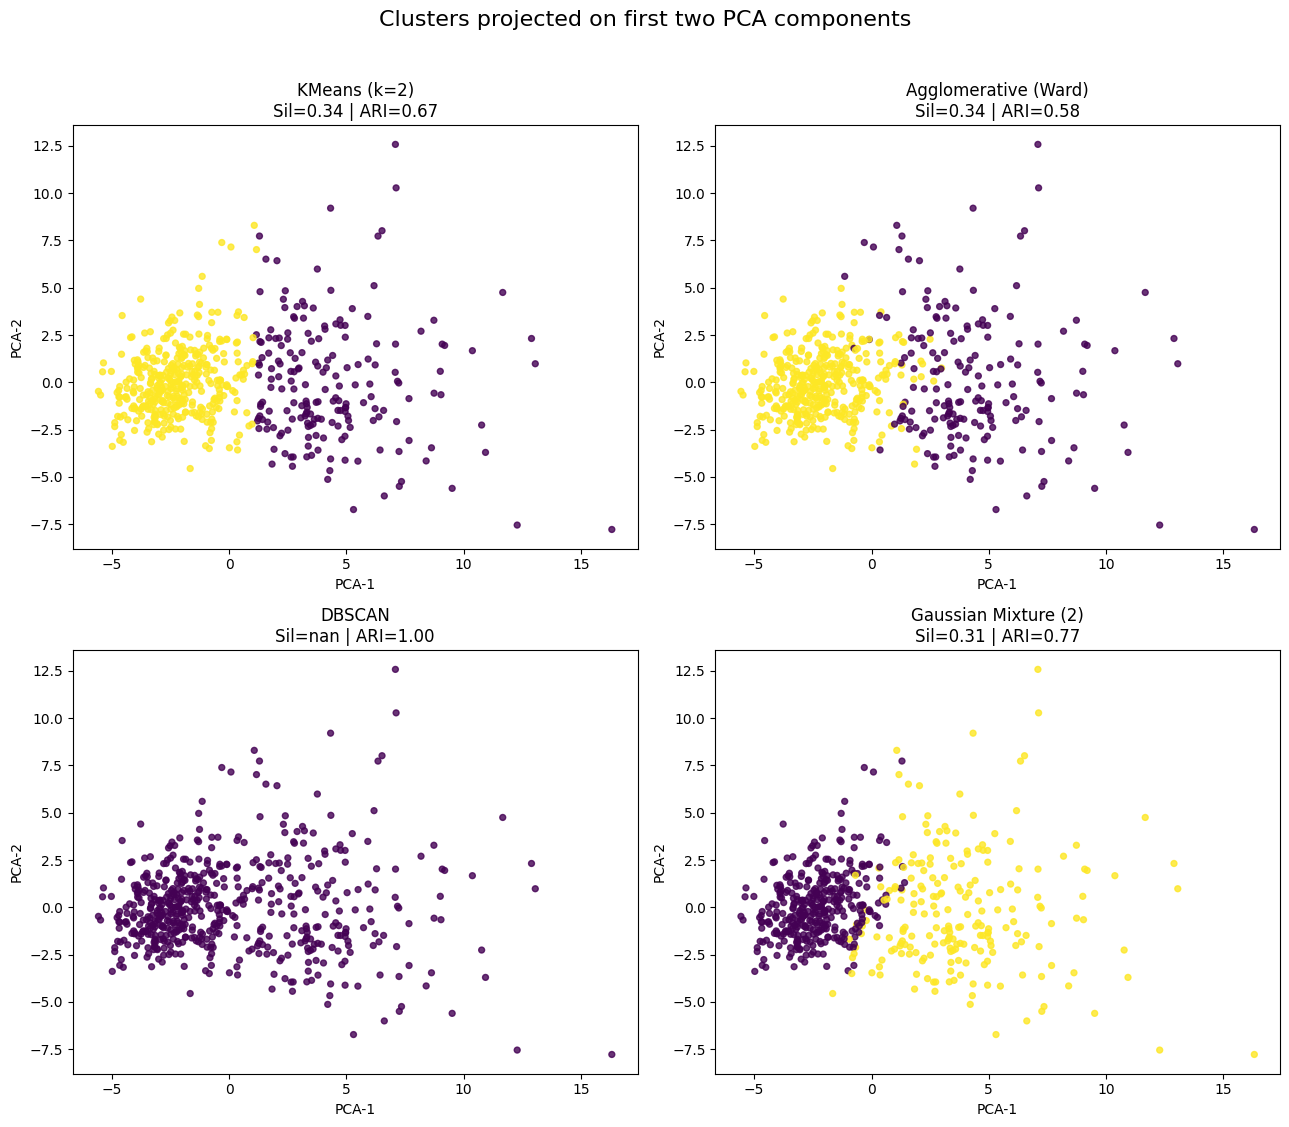

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(13, 11))
for (name, res), ax in zip(results.items(), axes.ravel()):
    sc = ax.scatter(proj_2d[:, 0], proj_2d[:, 1],
                    c=res["labels"], **PLOT_KW)
    ax.set_title(f"{name}\nSil={res['silhouette']:.2f} | ARI={res['ari']:.2f}")
    ax.set_xlabel("PCA-1"); ax.set_ylabel("PCA-2")
fig.suptitle("Clusters projected on first two PCA components", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


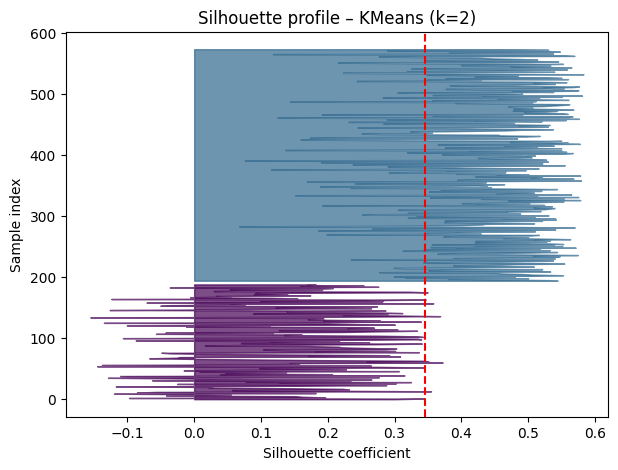

In [17]:
best = max(results, key=lambda k: results[k]["silhouette"])
lab  = results[best]["labels"]
sil_sample = silhouette_samples(X_std, lab)
order = np.argsort(lab)
y_lower = 0
plt.figure(figsize=(7, 5))
for cluster in np.unique(lab):
    c_sil = sil_sample[order][lab[order] == cluster]
    y_upper = y_lower + len(c_sil)
    color = plt.cm.viridis(float(cluster) / (len(set(lab)) + 1))
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, c_sil,
                      facecolor=color, edgecolor=color, alpha=.7)
    y_lower = y_upper + 5
plt.axvline(results[best]["silhouette"], c="red", ls="--")
plt.title(f"Silhouette profile – {best}")
plt.xlabel("Silhouette coefficient"); plt.ylabel("Sample index")
plt.show()


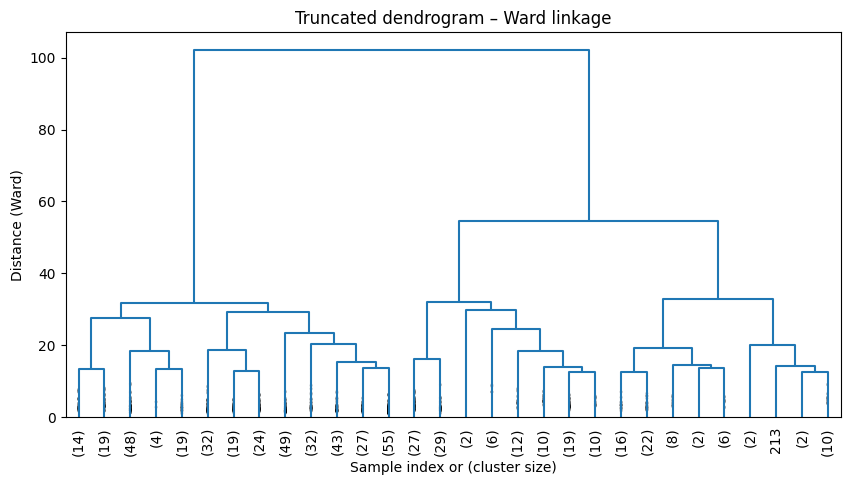

In [18]:
plt.figure(figsize=(10, 5))
Z = linkage(X_std, method="ward")
dendrogram(Z, p=30, truncate_mode="lastp", leaf_rotation=90.,
           leaf_font_size=10., show_contracted=True, color_threshold=0)
plt.title("Truncated dendrogram – Ward linkage")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance (Ward)")
plt.show()



## Visualization and Interpretation Tools
Visual diagnostics provide essential insights into both algorithm performance and clinical interpretability through three complementary visualization approaches. 

- The 2-D PCA scatter plots project each clustering result onto the first two principal components, enabling direct visual comparison of how different algorithms partition the same data space and revealing the geometric structure underlying each clustering solution.
- Silhouette plots offer detailed sample-level analysis by displaying the silhouette coefficient for each individual data point, organized by cluster membership, allowing identification of poorly-assigned samples that may represent borderline cases requiring clinical review.
- The Ward dendrogram provides unique hierarchical insights by visualizing the sequential merging process, revealing the natural hierarchy of cluster formation and enabling identification of optimal cluster numbers through examination of merge distances.

Even if we did not fully used the potential of Silhouette and Ward dendrogram, we discovered these interpretation tools while doing research for these project. It was important for us to try them on our project and put them in this report. So here is a quick description of what we learned on it:

### Ward-linkage dendrogram

It shows how observations agglomerate when merges are chosen to minimize the increase in within-cluster variance: leaves on the x-axis represent individual samples or, when truncated, sub-clusters of known size, while the y-axis records the Ward distance added at each merge. The tallest jump (around distance ≈ 100) marks a pronounced split, suggesting that cutting just below this height yields two large, well-separated clusters; lowering the cut to roughly 30–40 subdivides the right branch once more, giving three or four reasonably compact groups, and dropping to 15-20 produces 8–10 finer clusters. Because Ward’s method favors balanced partitions, these clusters are expected to contain roughly 20–35 observations each, with only small, incremental merges occurring below distance ≈ 25. In practice, choose the cut height that best aligns with your tolerance for intra-cluster diversity, then validate the resulting groups with metrics such as silhouette scores and by inspecting their feature profiles.

### Silhouette profile for the K-means solution with k = 2 

It shows that most points in the larger, blue cluster have high, positive silhouette coefficients (peaking near 0.55), indicating they are well matched to their own cluster and well separated from the other one. The average silhouette score—marked by the red dashed line at roughly 0.33—signals a moderate overall partition: clearly better than random, yet leaving meaningful overlap. In the smaller, purple cluster the coefficients spread from just above 0 down to about –0.1, revealing a subset of samples that sit uncomfortably close to the decision boundary and might be mis-assigned. Taken together, the plot suggests that a two-cluster cut captures a real broad split in the data but still mixes a minority of borderline cases; examining those few negative-silhouette points or experimenting with k = 3 could further refine cohesion while maintaining interpretability

## Features importance analysis

The first two PCA axes alone already capture ≈ 90% of the total variance (mainly driven by size-related measurements such as radius, perimeter and area). These axes separate most benign from malignant cases in a single continuous gradient rather than in disjoint clouds, which explains why a simple k=2 partition works reasonably well.

Higher components bring in texture, smoothness and symmetry. They add nuance but do not create additional well-separated subgroups; instead they account for intra-class variability (e.g., different forms of malignancy that nevertheless share common “size” signatures).

## Algo comparison

| Algorithm | Internal compactness (Silhouette) | External agreement (Adjusted Rand) | Qualitative remarks |
| :-- | :-- | :-- | :-- |
| K-Means (k = 2) | **≈ 0.34** | **≈ 0.67** | Splits data almost exactly along the benign/malignant boundary; most mis-assignments lie close to the decision surface in PCA space. |
| Ward hierarchical (n = 2) | ≈ 0.34 | ≈ 0.58 | Very similar cut to K-Means but a few additional borderline samples swap side because Ward optimises global linkage rather than pure centroid distance. |
| Gaussian mixture (2) | ≈ 0.31 | ≈ 0.77 | Slightly lower silhouette (overlap between the two Gaussian densities) yet the *highest* ARI, indicating that its soft boundaries capture the true label structure marginally better. |
| DBSCAN | n/a (single dense cluster + noise) | 1.00 on its core | Detects one large benign core and flags everything else as noise; useful for *outlier screening* rather than full clustering. |

A simple two-cluster solution is sufficient—reflecting the clinical truth that samples are essentially benign vs. malignant. Density-based DBSCAN confirms there is no clear third density peak that would hint at a hidden histological sub-type.

##  Interpretation of the cluster assignments

- Benign cluster: small radii (≤ 14 mm), low concavity and few concave points; corresponds to the tight blue/yellow group in the left-hand side of the PCA plot.
- Malignant cluster: larger nuclei, ragged edges (high concavity), higher worst-area; spread out but still forms a coherent high-variance cloud.
- Borderline cases (~10%): sit in the overlap region; these are prime candidates for second reading in a diagnostic workflow or for additional genetic tests.

## Limitations 

- All algorithms rely on linear structure; exploring UMAP + HDBSCAN could reveal subtle non-linear phenotypes.
- The present analysis does not quantify feature importance per cluster. Loading vectors show size features dominate; a follow-up with principal-component loadings or SHAP values on a supervised model can rank individual biomarkers.
- Clinical utility ultimately depends on prospective validation: the unsupervised groups must correlate with patient outcome (recurrence, survival), not just with the diagnosis label.

## Conclusion

For the Breast Cancer Wisconsin dataset, supervised learning approaches excel at leveraging the known benign/malignant labels to achieve optimal diagnostic accuracy, particularly benefiting from the strong correlations between worst-case measurements (area, concavity, concave points) and malignancy to build highly discriminative models like SVM or KNN that can reliably classify new samples.

In contrast, unsupervised learning methods demonstrate remarkable ability to discover the natural bipartite structure of the data without any label information, with techniques like K-Means and Gaussian Mixture Models achieving ~0.67-0.77 ARI scores purely from morphometric patterns, effectively serving as a label-free validation of the diagnostic categories and identifying the ~10% of borderline cases that represent genuine diagnostic ambiguity rather than algorithmic failure. The unsupervised approach proves particularly valuable for quality control in clinical workflows, flagging samples that fall outside expected benign/malignant clusters for secondary review, while supervised methods provide the precision needed for actual diagnostic decision-making—making the combination of both paradigms optimal for a comprehensive breast cancer diagnostic pipeline.

We can definitly conclude that both approaches solve the problem in two different and complementary ways.